# Learning of Material Properties via Gradient Descent

This notebook reproduces the results for the example application "Learning of radio materials" in the paper [Sionna RT: Differentiable Ray Tracing for Radio Propagation Modeling](https://arxiv.org/abs/2303.11103).

It requires [Sionna](https://github.com/NVlabs/sionna) v0.14 or later.


## Imports and GPU Configuration

In [1]:
import os

# Configure which GPU 
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

from sionna.rt import load_scene, RadioMaterial, PlanarArray, Transmitter, Receiver, Paths2CIR
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel

2023-03-17 13:22:37.093702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configure the Scene and Generate Reference Data

In this example, we will load the scene "etoile" which is already available in Sionna.
We will then place a single transmitter and a few hundred receivers within the scene. The receiver locations define the points and which the channel impulse reponses will be computed.


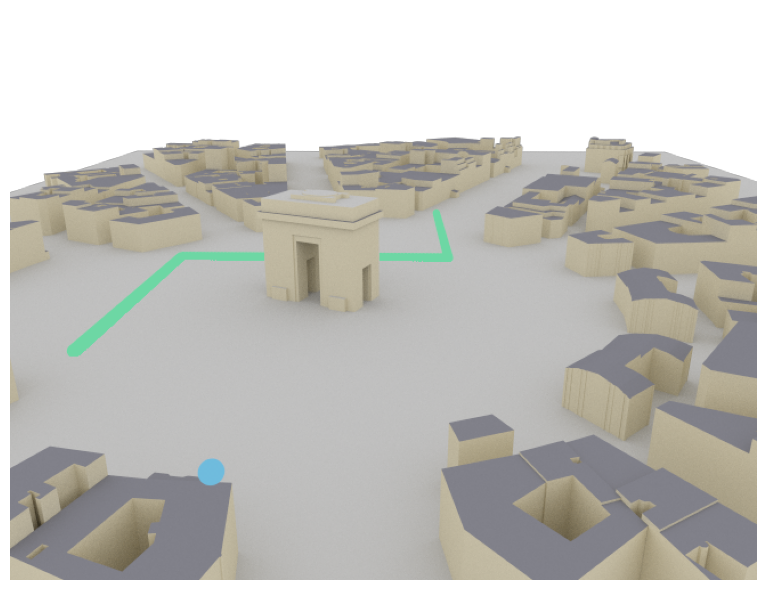

In [2]:
# Load the scene
scene = load_scene(sionna.rt.scene.etoile)

# Configure the transmit array
scene.tx_array = PlanarArray(num_rows=1, num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure the receive array (use by all receivers in the scene)
scene.rx_array = PlanarArray(num_rows=1, num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create a transmitter and add it to the scene
tx = Transmitter("tx", position=[-302, 42, 23.0], orientation=[0,0,0])
scene.add(tx)

# Create a large number of receivers and add them to the scene
for i in range(0,130,2):
    rx = Receiver(f"rx+{i}", position=[-195+i, 125, 1.5], orientation=[0,0,0])
    scene.add(rx)

for i in range(130,280, 2):
    rx = Receiver(f"rx+{i}", position=[-66, 125-i+129, 1.5], orientation=[0,0,0])
    scene.add(rx)
    
for i in range(280,400,2):
    rx = Receiver(f"rx+{i}", position=[-66+i-280, -26, 1.5], orientation=[0,0,0])
    scene.add(rx)

# Preview the scene
# The transmitter is indicated by a blue ball, the receivers by green balls
scene.render("scene-cam-0", fov=60);

Next, we will simulate channel impulse responses at all receiver locations and convert them to the frequency domain, assuming that perfect channel estimation is available using OFDM. These channel frequency responses will be our *measurements* or labels. 

In [3]:
# Compute propagation paths 
# We limit the ray tracing to a maximum of three bounces and shoot 1M rays
paths = scene.compute_paths(max_depth=3, num_samples=1e6, seed=10)

# Convert paths to channel impulse responses
p2c = Paths2CIR(sampling_frequency=1, # This parameters has no meaning as we sample the channel only once
                num_time_steps=1,     # We sample only once as we have not defined any mobility
                scene=scene)

a, tau = p2c(paths.as_tuple())

# Convert channel impulse responses to frequency responses
frequencies = subcarrier_frequencies(num_subcarriers=128,
                                     subcarrier_spacing=30e3)

h_freq = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)

# Visualize the propagation paths in the scene
# Note that this will update the preview above
# as there is only a single preview instance per notebook
#scene.preview(paths);

In [4]:
scene.render_to_file("scene-cam-0", "mat.png", num_samples=4096, resolution=[700, 400], fov=60)

## Replace Materials by Trainable Materials

We assume now that the radio materials in the scene are unknown and replace them by trainable materials that are initialized with some default value.

Let us first check which materials are used in the scene and how many objects are made of each of them:

In [5]:
for mat in list(scene.radio_materials.values()):
    if mat.is_used:
        print(f"Name: {mat.name}, Used by {mat.use_counter} scene objects.")

Name: itu_concrete, Used by 2 scene objects.
Name: itu_wood, Used by 1 scene objects.
Name: itu_marble, Used by 280 scene objects.
Name: itu_metal, Used by 280 scene objects.


In this scene, the street level is made of concrete. All building walls are made of marble, the roofs are made of metal, and a single object, namely the Arc de Triomphe, has a small part made of wood (to be precise, it is the ceiling inside it).

Next, we create for each of these materials a trainable replacement and assign it to the corresponding objects.
We could have also assigned to every object its own trainable material. This makes the training much longer and is out of the scope of this notebook.

In [6]:
# Create for every used material a trainable material

# Some lists for book-keeping
original_materials = []
trainable_materials = []

for mat in list(scene.radio_materials.values()):
    if mat.is_used:        
        # Create new trainable material with some default values
        new_mat = RadioMaterial(mat.name + "_train",
                                relative_permittivity=3.0,
                                conductivity=0.1,
                                trainable=True)
        scene.add(new_mat)
        trainable_materials.append(new_mat)
        original_materials.append(mat)
        
# Assign trainable materials to the corresponding objects
for obj in list(scene.objects.values()):
    obj.radio_material = obj.radio_material.name + "_train"

Let's check if the radio materials have been correctly replaced:

In [7]:
for mat in list(scene.radio_materials.values()):
    if mat.is_used:
        print(f"Name: {mat.name}, Used by {mat.use_counter} scene objects.")

Name: itu_concrete_train, Used by 2 scene objects.
Name: itu_wood_train, Used by 1 scene objects.
Name: itu_marble_train, Used by 280 scene objects.
Name: itu_metal_train, Used by 280 scene objects.


The constituent parameters of a material can be accessed as follows. For a definition, please have a look at the [Sionna documentation](https://nvlabs.github.io/sionna/em_primer.html#planar-time-harmonic-waves).

In [8]:
print(scene.radio_materials["itu_concrete"].relative_permittivity)
print(scene.radio_materials["itu_concrete"].conductivity)
print(scene.radio_materials["itu_concrete"].complex_relative_permittivity)

tf.Tensor(5.24, shape=(), dtype=float32)
tf.Tensor(0.123086944, shape=(), dtype=float32)
tf.Tensor((5.24-0.63214296j), shape=(), dtype=complex64)


## Learn Radio Material Properties by Gradient Descent

Now, we will try to recover the original material properties by comparing channel frequency responses generated by the trainable materials to those generated by the original materials, i.e., our *measured* data set. This will be done via gradient descent on the normalized mean squared error.

In [9]:
# Configure an SGD optimizer
optimizer = tf.keras.optimizers.Adam(1.5e-1)

num_steps = 100 # Number of training steps

# Placeholders to visualize training progress
conductivities = np.zeros([num_steps, len(trainable_materials)])
relative_permittivities = np.zeros([num_steps, len(trainable_materials)])

def train_step():
    """A single training step"""
    with tf.GradientTape() as tape:
        
        # Compute paths
        paths = scene.compute_paths(max_depth=3, num_samples=1e6, seed=1)
        
        # Transform paths to channel impulse responses
        a, tau = p2c(paths.as_tuple())
        
        # Compute channel frequency responses
        h_freq_hat = cir_to_ofdm_channel(frequencies, a, tau, normalize=False)
        
        # Compute normalized MSE
        loss = tf.reduce_mean(tf.abs(h_freq-h_freq_hat)**2)/tf.reduce_mean(tf.abs(h_freq)**2)
    
    # Compute gradients and apply through the optimizer
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

def check_mat(mat):
    """We need to make sure that material properties are always valid"""
    if mat.conductivity < 0: # Non-negative conductivity
        mat.conductivity = 0 
    if mat.relative_permittivity < 1: # Relative permittivity not smaller than 1
        mat.relative_permittivity = 1

for step in range(num_steps):       
    loss = train_step()
    print(f"Training step {step} - Loss: {loss.numpy()}", end="\r")
    
    for i, mat in enumerate(trainable_materials):
        check_mat(mat)
        conductivities[step, i] = mat.conductivity
        relative_permittivities[step, i] = mat.relative_permittivity

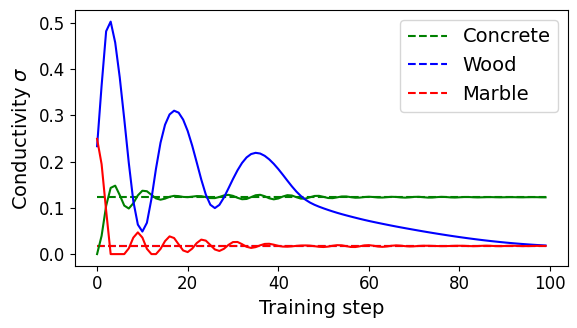

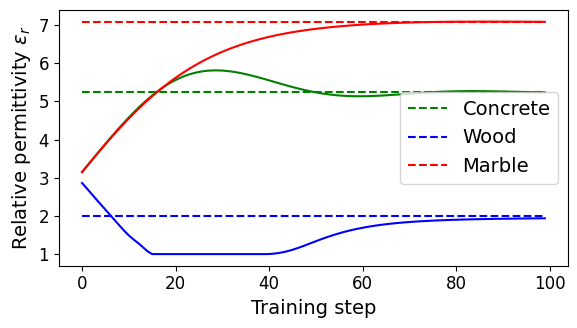

In [10]:
plt.rc('font', size=14)          
plt.rc('axes', titlesize=14)     
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=12)    
plt.rc('ytick', labelsize=12)   
plt.rc('legend', fontsize=14)    

plt.figure(figsize=(6,3.5))
colors = ["g", "b", "red"]
for i in range(3):
    plt.plot(np.repeat(original_materials[i].conductivity, num_steps), '--', color=colors[i])
for i in range(3):
    plt.plot(conductivities[:,i], '-', color=colors[i])
plt.xlabel("Training step")
plt.ylabel(r"Conductivity $\sigma$")
plt.legend(["Concrete", "Wood", "Marble"]);
plt.tight_layout()

plt.figure(figsize=(6,3.5))
colors = ["g", "b", "red"]
for i in range(3):
    plt.plot(np.repeat(original_materials[i].relative_permittivity, num_steps), '--', color=colors[i])
for i in range(3):
    plt.plot(relative_permittivities[:,i], '-', color=colors[i])
plt.xlabel("Training step")
plt.ylabel(r"Relative permittivity $\varepsilon_r$")
plt.legend(["Concrete", "Wood", "Marble"]);
plt.tight_layout()

## Discussion

Learning of materials via gradient descent works nicely in this scenario, as can be seen from the results above. Surprisingly, even the material "Wood" which is only used by a single object can be learned with high precision, although it requires more training steps.

- Note that only specular reflections are considered in this notebook. Studying the impact of other propagation effects on the learning process, such as refraction, diffraction, and scattering, are interesting future investigations.

- We have trained here on channel frequency responses. It is unlikely that this approach would work with measured data, as accurate phase information can rarely be predicted via ray tracing. A more practical approach could be to train on coverage maps. This is an open research field and many other options are possible.

- We have assumed here that many objects in the scene share the same materials. In practice, this is not the case, and one could assign a different material to each object or groups of objects. This will then increase the training complexity.

- One could use computer vision methods to assign coarse estimates of material properties to all objects in a scene. These could then be fine-tuned via learning.

- Learning of radio materials can be seen as an automated *calibration* of a ray tracer to measurements. It is hence an important step toward the creation of digital twin networks.